In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
if not os.path.exists('./save_images/dcgan_faces_multip_gpu'): os.mkdir('./save_images/dcgan_faces_multip_gpu')

In [5]:
batch_size = 64
num_epochs = 1000

z_dimension = 100
d = 128

In [6]:
device_ids = [0, ] # [0, 1]

In [7]:
img_transform = transforms.Compose([
#     transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.ImageFolder('~/data/anime-faces', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [8]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

\begin{equation}
H_{out} = \left\lfloor\frac{H_{in}  + 2 * \text{padding}[0] - \text{dilation}[0]
          * (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 * \text{padding}[1] - \text{dilation}[1]
          * (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
\end{equation}

In [9]:
class Discriminator(nn.Module): # b 3 96 96
    def __init__(self, d):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1) # b d 48 48
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1) # b d*2 24 24
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1) # b d*4 12 12
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1) # b d*8 6 6
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*16, 4, 1, 0) # b d*8 3 3
        self.conv5_bn = nn.BatchNorm2d(d*16)
        self.conv6 = nn.Conv2d(d*16, 1, 3, 1, 0)
        
#         self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
#         self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
#         self.conv2_bn = nn.BatchNorm2d(d*2)
#         self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
#         self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
#         self.conv4_bn = nn.BatchNorm2d(d*8)
#         self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x): # b 3 96 96
        outs = F.leaky_relu(self.conv1(x), 0.2)
        outs = F.leaky_relu(self.conv2_bn(self.conv2(outs)), 0.2)
        outs = F.leaky_relu(self.conv3_bn(self.conv3(outs)), 0.2)
        outs = F.leaky_relu(self.conv4_bn(self.conv4(outs)), 0.2)
        outs = F.leaky_relu(self.conv5_bn(self.conv5(outs)), 0.2)
        outs = torch.sigmoid(self.conv6(outs))

#         outs = F.leaky_relu(self.conv1(x), 0.2)
#         outs = F.leaky_relu(self.conv2_bn(self.conv2(outs)), 0.2)
#         outs = F.leaky_relu(self.conv3_bn(self.conv3(outs)), 0.2)
#         outs = F.leaky_relu(self.conv4_bn(self.conv4(outs)), 0.2)
#         outs = F.sigmoid(self.conv5(outs))

        return outs

\begin{equation}
H_{out} = (H_{in} - 1) * \text{stride}[0] - 2 * \text{padding}[0]
      + \text{kernel_size}[0] + \text{output_padding}[0]\\W_{out} = (W_{in} - 1) * \text{stride}[1] - 2 * \text{padding}[1]
      + \text{kernel_size}[1] + \text{output_padding}[1]
\end{equation}

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dimension, d): # b 100 1 1
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(z_dimension, d*8, 3, 1, 0) # b d*8 3 3
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1) # b d*4 6 6
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1) # b d*2 12 12
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1) # b d 24 24
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, int(d/2), 4, 2, 1) # b 3 48 48
        self.deconv5_bn = nn.BatchNorm2d(int(d/2))
        self.deconv6 = nn.ConvTranspose2d(int(d/2), 3, 4, 2, 1) # b 3 96 96
        
#         self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
#         self.deconv1_bn = nn.BatchNorm2d(d*8)
#         self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
#         self.deconv2_bn = nn.BatchNorm2d(d*4)
#         self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
#         self.deconv3_bn = nn.BatchNorm2d(d*2)
#         self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
#         self.deconv4_bn = nn.BatchNorm2d(d)
#         self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        outs = F.relu(self.deconv1_bn(self.deconv1(x)))
        outs = F.relu(self.deconv2_bn(self.deconv2(outs)))
        outs = F.relu(self.deconv3_bn(self.deconv3(outs)))
        outs = F.relu(self.deconv4_bn(self.deconv4(outs)))
        outs = F.relu(self.deconv5_bn(self.deconv5(outs)))
        outs = torch.tanh(self.deconv6(outs))
#         outs = F.relu(self.deconv1_bn(self.deconv1(x)))
#         outs = F.relu(self.deconv2_bn(self.deconv2(outs)))
#         outs = F.relu(self.deconv3_bn(self.deconv3(outs)))
#         outs = F.relu(self.deconv4_bn(self.deconv4(outs)))
#         outs = F.tanh(self.deconv5(outs))
        return outs

In [11]:
d = Discriminator(128)#.cuda(device_ids[0])
g = Generator(z_dimension, 128)#.cuda(device_ids[0])

d.weight_init(0.0, 0.02)
g.weight_init(0.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)


criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=2e-4)
# d_optimezer = nn.DataParallel(d_optimezer, device_ids=device_ids)
g_optimezer = optim.Adam(g.parameters(), lr=2e-4)
# g_optimezer = nn.DataParallel(g_optimezer, device_ids=device_ids)

In [12]:
writer = SummaryWriter('./log/dcgan_faces_multip_gpu')

In [13]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    
    d_loss_total = .0
    g_loss_total = .0
    _step = epoch * total_count
    for i, (img, _) in enumerate(dataloader):
        
        mini_batch = img.size(0)
        
        real_img = img.cuda()
#         real_labels = torch.ones(mini_batch, 1, 1, 1).cuda()
#         fake_labels = torch.zeros(mini_batch, 1, 1, 1).cuda()
        real_labels = torch.FloatTensor(mini_batch, 1, 1, 1).uniform_(.9, 1).cuda()
        fake_labels = torch.FloatTensor(mini_batch, 1, 1, 1).uniform_(0, .1).cuda()
        
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(mini_batch, z_dimension).view(-1, z_dimension, 1, 1).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(mini_batch, z_dimension).view(-1, z_dimension, 1, 1).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)

        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        d_loss_total += d_loss.item() * mini_batch
        g_loss_total += g_loss.item() * mini_batch
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 200 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    setp = (epoch + 1) * total_count
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 3, 96, 96).cpu().data, normalize=True, scale_each=True), step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    if epoch == 0:
        real_images = real_img.view(-1, 3, 96, 96).cpu().data
        save_image(real_images, './save_images/dcgan_faces_multip_gpu/real_images.png')

    fake_images = fake_img.view(-1, 3, 96, 96).cpu().data
    save_image(fake_images, './save_images/dcgan_faces_multip_gpu/fake_images-{}.png'.format(epoch+1))

Epoch [1/1000], Step:  12800, d_loss: 2.913073, g_loss: 47.751400, real_scores: 0.933772, fake_scores: 0.000000
Epoch [1/1000], Step:  25600, d_loss: 2.271025, g_loss: 42.179375, real_scores: 0.923480, fake_scores: 0.000000
Epoch [1/1000], Step:  38400, d_loss: 2.317545, g_loss: 39.426559, real_scores: 0.901629, fake_scores: 0.000000
Epoch [1/1000], Step:  51200, d_loss: 2.111511, g_loss: 37.273228, real_scores: 0.951699, fake_scores: 0.000000
Epoch [1/1000], Step:  64000, d_loss: 0.502399, g_loss: 3.990469, real_scores: 0.942675, fake_scores: 0.092238
Epoch [1/1000], Step:  76800, d_loss: 0.451753, g_loss: 3.312576, real_scores: 0.904662, fake_scores: 0.044218
Epoch [1/1000], Step:  89600, d_loss: 0.424123, g_loss: 3.194424, real_scores: 0.968254, fake_scores: 0.072553
Epoch [1/1000], Step: 102400, d_loss: 0.406951, g_loss: 2.676986, real_scores: 0.944534, fake_scores: 0.068892
Finish Epoch [1/1000], D Loss: 90.654563, G Loss: 1386.171056
Epoch [2/1000], Step:  12800, d_loss: 0.421751

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: 

In [14]:
writer.close()

In [15]:
torch.save(d.state_dict(), './ser/dcgan_faces_discriminator_m_gpu.pkl')
torch.save(g.state_dict(), './ser/dcgan_faces_generator_m_gpu.pkl')

torch.Size([4, 3, 64, 64])


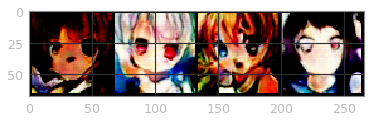

In [21]:
z = torch.randn(4, z_dimension).view(-1, z_dimension, 1, 1).to(device)
images = g(z)
# save_image(images, 'xx.png')

plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()